In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rc("font", family="Malgun Gothic")

# 0. 데이터 확인

In [15]:
df_info = pd.read_csv('./open/data_info.csv')
df_sample_submission = pd.read_csv('./open/sample_submission.csv')
df_test = pd.read_csv('./open/test.csv')
df_train = pd.read_csv('./open/train.csv')
df_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [16]:
df_train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [17]:
df_train = df_train.drop('id', axis=1) #id는 결국 idx와 동치이므로 제거
df_test = df_test.drop('id',axis=1)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   base_date              int64  
 1   day_of_week            object 
 2   base_hour              int64  
 3   lane_count             int64  
 4   road_rating            int64  
 5   road_name              object 
 6   multi_linked           int64  
 7   connect_code           int64  
 8   maximum_speed_limit    float64
 9   vehicle_restricted     float64
 10  weight_restricted      float64
 11  height_restricted      float64
 12  road_type              int64  
 13  start_node_name        object 
 14  start_latitude         float64
 15  start_longitude        float64
 16  start_turn_restricted  object 
 17  end_node_name          object 
 18  end_latitude           float64
 19  end_longitude          float64
 20  end_turn_restricted    object 
 21  target                 float64
dtypes: float64(9), int

In [19]:
df_train["base_date"] = pd.to_datetime(df_train["base_date"],format='%Y%m%d')
df_test["base_date"] = pd.to_datetime(df_test["base_date"],format='%Y%m%d')

In [7]:
df_train.describe().T.sort_values(by='std', ascending=False).style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
weight_restricted,4701217.000000,5618.742381,13953.433235,0.000000,0.000000,0.000000,0.000000,50000.000000
target,4701217.000000,42.788442,15.954434,1.000000,30.000000,43.000000,54.000000,113.000000
maximum_speed_limit,4701217.000000,61.253292,12.133539,30.000000,50.000000,60.000000,70.000000,80.000000
base_hour,4701217.000000,11.928196,6.722092,0.000000,6.000000,12.000000,18.000000,23.000000
connect_code,4701217.000000,0.266022,5.227760,0.000000,0.000000,0.000000,0.000000,103.000000
road_rating,4701217.000000,104.958500,1.840107,103.000000,103.000000,106.000000,107.000000,107.000000
road_type,4701217.000000,0.615224,1.211268,0.000000,0.000000,0.000000,0.000000,3.000000
lane_count,4701217.000000,1.836651,0.687751,1.000000,1.000000,2.000000,2.000000,3.000000
start_longitude,4701217.000000,126.521684,0.156366,126.182617,126.423200,126.511195,126.583975,126.930941
end_longitude,4701217.000000,126.521695,0.156352,126.182617,126.423200,126.511195,126.583975,126.930941


In [20]:
#multi_linked, vehicle_restricted, height_restricted의 표준편차가 매우작은것으로 보아 값이 별로 없을 수 있음
noVal = ['multi_linked', 'vehicle_restricted', 'height_restricted']
for col in (noVal):
    print(df_train[col].value_counts())
    print(df_test[col].value_counts())

0    4698978
1       2239
Name: multi_linked, dtype: int64
0    291241
Name: multi_linked, dtype: int64
0.0    4701217
Name: vehicle_restricted, dtype: int64
0.0    291241
Name: vehicle_restricted, dtype: int64
0.0    4701217
Name: height_restricted, dtype: int64
0.0    291241
Name: height_restricted, dtype: int64


In [21]:
print('multi_linked prop: {0:.4f}'.format(2239/4698978))

multi_linked prop: 0.0005


In [22]:
#셋 다 무의미하므로 drop
df_train = df_train.drop(noVal, axis=1)
df_test = df_test.drop(noVal, axis=1)

In [23]:
df_train.info() #연산 속도를 고려하여 64비트 dtype들을 따로 변환해줄 필요가 있음..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int64         
 3   lane_count             int64         
 4   road_rating            int64         
 5   road_name              object        
 6   connect_code           int64         
 7   maximum_speed_limit    float64       
 8   weight_restricted      float64       
 9   road_type              int64         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_latitude           float64       
 16  end_longitude          float64       
 17  end_turn_restricted    object        
 18  target                

In [24]:
def change_dtype(df, col,dtype):
    """
    dtype = str ex. "int 32", "float 32"
    """
    for i in col:
        df[i] = df[i].astype(dtype)

In [30]:
change_dtype(df_train, df_train.select_dtypes('int64').columns, 'int32')
change_dtype(df_train, ['maximum_speed_limit', 'weight_restricted', 'target'], 'float32')

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int32         
 3   lane_count             int32         
 4   road_rating            int32         
 5   road_name              object        
 6   connect_code           int32         
 7   maximum_speed_limit    float32       
 8   weight_restricted      float32       
 9   road_type              int32         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_latitude           float64       
 16  end_longitude          float64       
 17  end_turn_restricted    object        
 18  target                

- Int32 -- (-2,147,483,648 to 2,147,483,647)
- float 32 -- 	(-3.4 x 10^38 to 3.4 x 10^38)

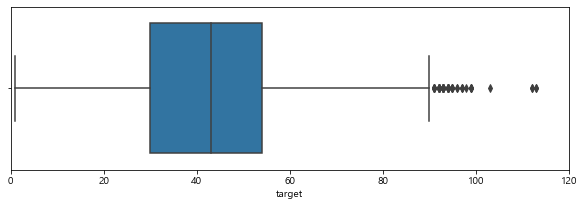

In [38]:
#outlier 확인
plt.figure(figsize=(10,3))
plt.xlim(0,120)
sns.boxplot(x=df_train['target'])

In [39]:
df_train['target'][df_train['target'] > 100]

242903     112.0
2607664    112.0
3841974    113.0
4386692    113.0
4559340    103.0
Name: target, dtype: float32

In [40]:
df_train['road_name'][df_train['target'] > 100] # outlier들의 과적합 방지를 위해 지우겠다.

242903     일반국도12호선
2607664    일반국도12호선
3841974    일반국도12호선
4386692    일반국도12호선
4559340    일반국도11호선
Name: road_name, dtype: object

In [41]:
df_train = df_train[df_train['target'] < 100]

# 1. NA확인

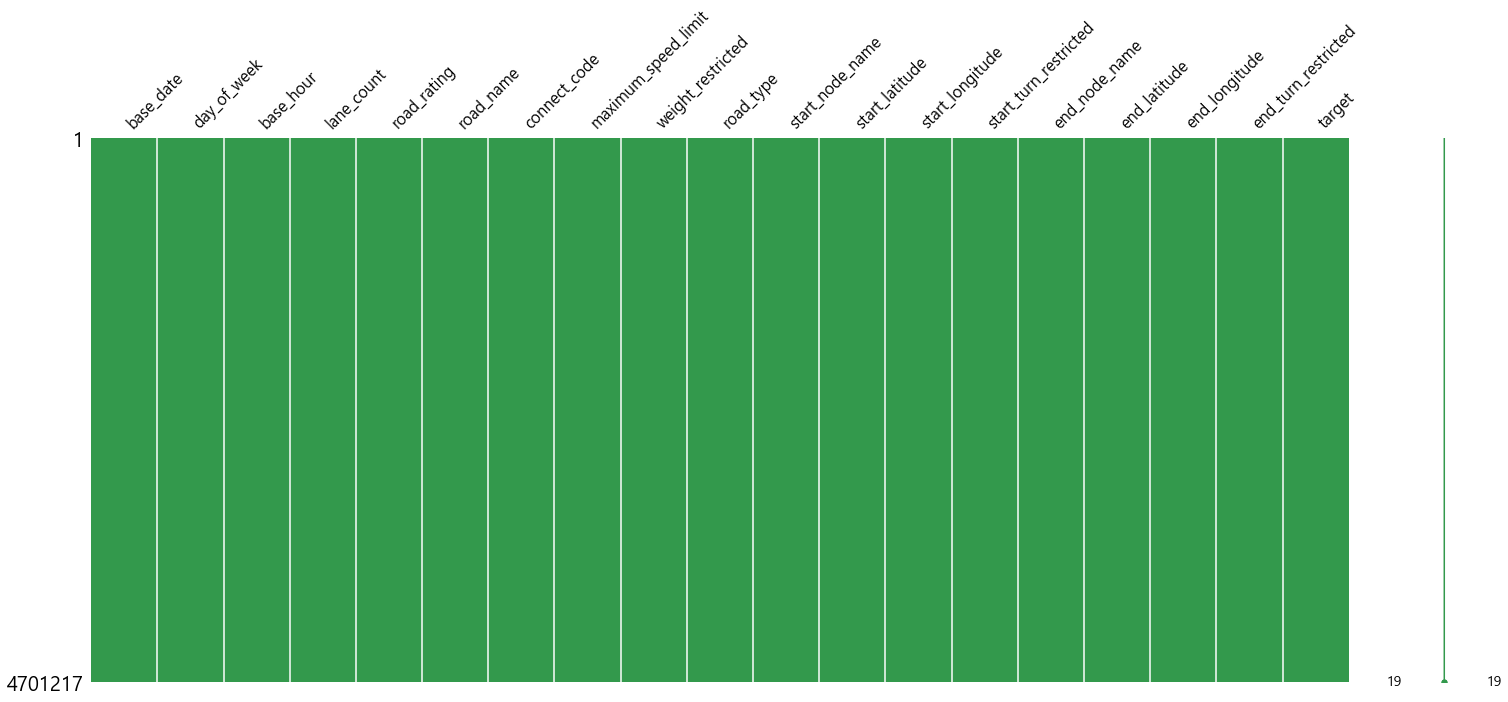

In [14]:
import missingno as msno
msno.matrix(df_train,color=(0.2,0.6,0.3)) # na 값이 없음

# 2. 상관관계 분석

In [15]:
df_train.corr()['target'].sort_values(ascending=False)

target                 1.000000
maximum_speed_limit    0.425715
weight_restricted      0.294092
road_type              0.200840
connect_code           0.048348
start_latitude         0.036280
end_latitude           0.036139
end_longitude         -0.001000
start_longitude       -0.001168
lane_count            -0.144256
base_hour             -0.159407
road_rating           -0.261693
Name: target, dtype: float64

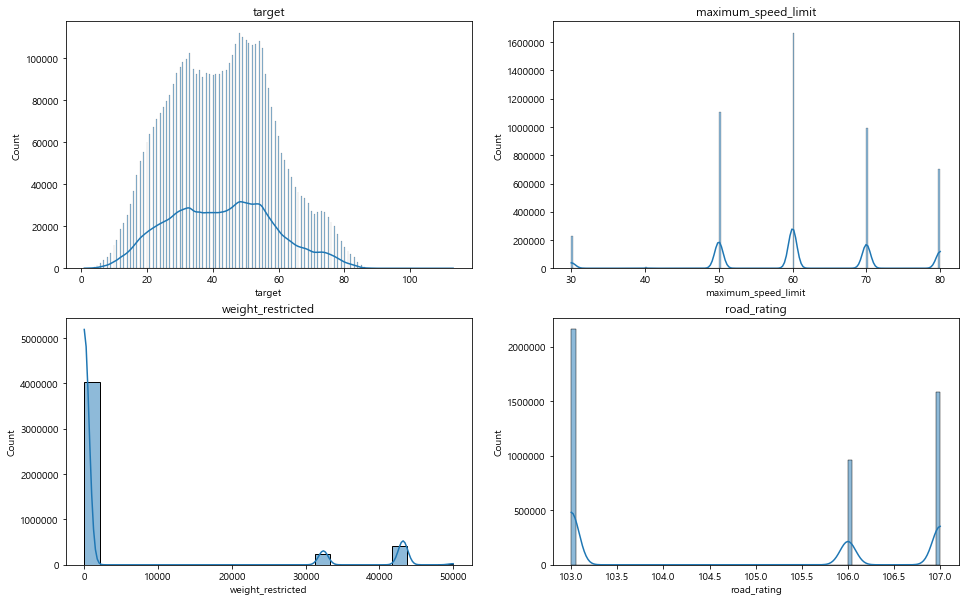

In [16]:
target_corr = abs(df_train.corr()['target']).sort_values(ascending=False)
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.histplot(df_train[target_corr.keys()[i]], kde=True)
    plt.title(target_corr.keys()[i])

1. maximum_speed_limit    0.425715
2. weight_restricted      0.294092
3. road_type              0.200840
4. connect_code           0.048348

## 2.1 다중 공선성 확인

In [17]:
corrs  = df_train.corr().sort_values('target', ascending=False)
threshold = .8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
above_threshold_vars # 시작,도착지점의 경위도 둘 중 하나는 제거해야함

{'base_hour': ['base_hour'],
 'lane_count': ['lane_count'],
 'road_rating': ['road_rating'],
 'connect_code': ['connect_code'],
 'maximum_speed_limit': ['maximum_speed_limit'],
 'weight_restricted': ['weight_restricted'],
 'road_type': ['road_type'],
 'start_latitude': ['start_latitude', 'end_latitude'],
 'start_longitude': ['end_longitude', 'start_longitude'],
 'end_latitude': ['start_latitude', 'end_latitude'],
 'end_longitude': ['end_longitude', 'start_longitude'],
 'target': ['target']}

In [57]:
df_train = df_train.drop(columns=['end_longitude', 'end_latitude'])
df_test = df_test.drop(columns=['end_longitude', 'end_latitude'])

# 3. 🛣️⏰시공간 분석

## 3.1 시간


    base_date              int64  
    day_of_week            object 
    base_hour              int64  

In [19]:
df_time = df_train[['base_date','day_of_week','base_hour','target']].copy()
df_time.head()

,base_date,day_of_week,base_hour,target
0,2022-06-23,목,17,52.0
1,2022-07-28,목,21,30.0
2,2021-10-10,일,7,61.0
3,2022-03-11,금,13,20.0
4,2021-10-05,화,8,38.0


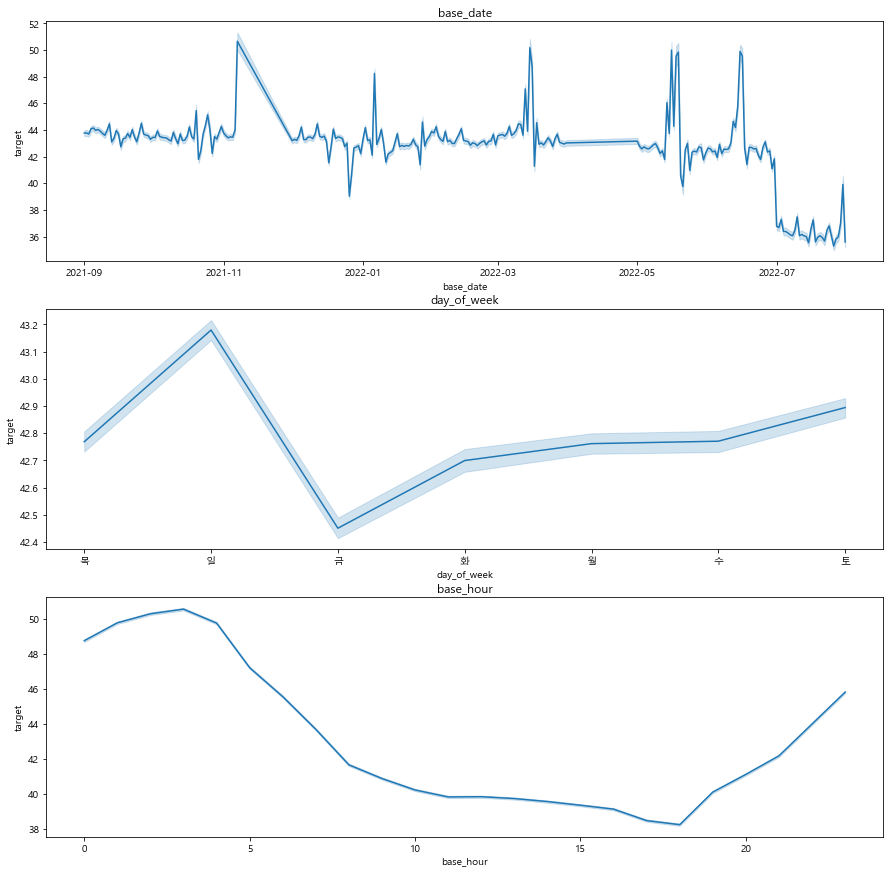

In [20]:
columns = np.array(df_time.columns)
plt.figure(figsize=(15,15))
for i in range(len(columns)-1):
    plt.subplot(3,1,i+1)
    sns.lineplot(x=df_time[columns[i]], y=df_time['target'])
    plt.title(columns[i])

In [21]:
df_time.groupby('day_of_week')['target'].mean().sort_values()

day_of_week
금    42.450328
화    42.699198
월    42.761365
목    42.768345
수    42.770372
토    42.894117
일    43.179300
Name: target, dtype: float64

1. base_date: 7월에서 target이 유의미하게 줄어들었다. 교통이 정체되었다는 것인데 방학 시즌이라 그런 것 같음. 2021년 12월즈음에 갑자기 target이 커지는데 아마도 겨울이기에 눈이 오니 당연히 차가 별로 안다닐 것으로 추정

2. day_of_week: 불금이라고 불리는 금요일이 가장 정체되는걸 알 수 있음. 이외로 일요일이 가장 target이 높음
3. base_hour: 당연히 새벽에 가장 정체가 없고, 퇴근시간이 가까워질 수록 정체가 심한걸 알 수 있음

## 3.2 공간

	road_rating	도로등급
	multi_linked	중용구간 여부
	connect_code	연결로 코드
	maximum_speed_limit	최고속도제한
	weight_restricted	통과제한하중
	height_restricted	통과제한높이
	road_type	도로유형

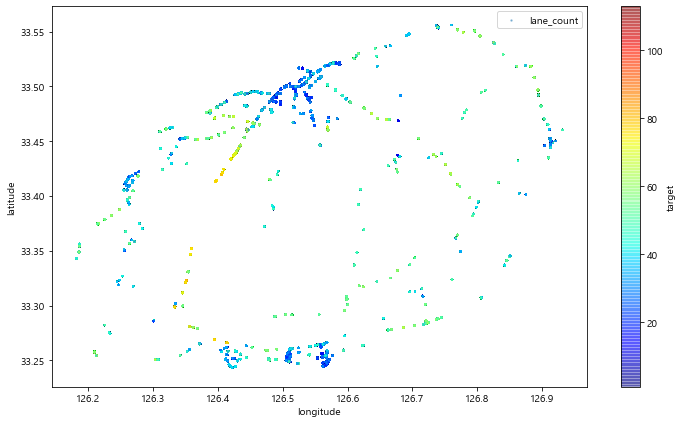

In [22]:
ax=df_train.plot(kind="scatter",x='start_longitude',y='start_latitude',alpha=.4,s=df_train['lane_count'],label='lane_count',
                figsize=(12,7),c='target',cmap=plt.get_cmap('jet'),colorbar=True,sharex=False)
ax.set(xlabel='longitude',ylabel='latitude')
plt.legend() #중부 산간 지방 또는 해안도로주변으로 갈수록 target이 커짐

찾아보니 2006년도에 제주도가 제주특별자치도로 바뀌면서 국도가 지방국도로 격하되었다고 한다.

- 일반국도 12호선 -> 지방도 1132호선
- 일반국도 11호선 -> 지방도 1131호선
- 일반국도 95호선 -> 지방도 1135호선
- 일반국도 16호선 -> 지방도 1136호선
- 일반국도 99호선 -> 지방도 1139호선

하지만 데이터에는 반영이 되지 않아서 같은 도로지만 서로 다른 2개의 표기를 둘다 사용하고 있다.

In [57]:
df_train['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

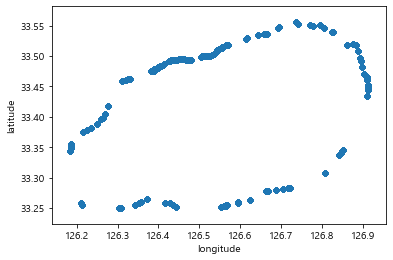

In [44]:
ax=df_train[df_train['road_name']== '일반국도12호선'].plot(kind="scatter",x='start_longitude',y='start_latitude')
ax.set(xlabel='longitude',ylabel='latitude')

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

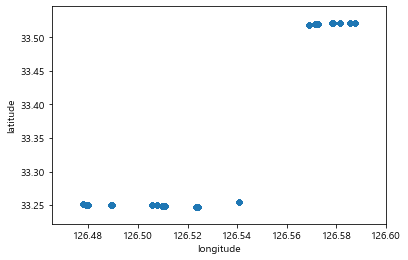

In [45]:
ax=df_train[df_train['road_name']== '지방도1132호선'].plot(kind="scatter",x='start_longitude',y='start_latitude')
ax.set(xlabel='longitude',ylabel='latitude')

# 4. 범주형 자료

In [60]:
df_train_categorical = df_train.select_dtypes('object').copy()
df_train_categorical.head()

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
0,목,지방도1112호선,제3교래교,없음,제3교래교,없음
1,목,일반국도11호선,광양사거리,있음,KAL사거리,없음
2,일,일반국도16호선,창고천교,없음,상창육교,없음
3,금,태평로,남양리조트,없음,서현주택,없음
4,화,일반국도12호선,애월샷시,없음,애월입구,없음


In [24]:
df_train_categorical['day_of_week'].value_counts()

금    684024
수    675583
목    674070
일    673632
토    669767
화    662498
월    661643
Name: day_of_week, dtype: int64

In [25]:
df_train_categorical['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

In [26]:
df_train_categorical[df_train_categorical['road_name']=='-']

,day_of_week,road_name,start_node_name,start_turn_restricted,end_node_name,end_turn_restricted
6,목,-,가동,없음,나동,없음
14,목,-,송목교,없음,송목교,없음
28,일,-,광평교차로,없음,금악,없음
30,목,-,일호유리,없음,상귀교차로,없음
31,목,-,남수교,없음,남수교,없음
...,...,...,...,...,...,...
4701204,금,-,한남교차로,없음,서중2교,없음
4701205,수,-,감귤창고,없음,수협,없음
4701208,수,-,제2태흥교,없음,제2태흥교,없음
4701212,목,-,대림사거리,없음,금덕해운,없음


In [27]:
print('표기안된 도로 비율: {0:.4f}%'.format(569463/4701217)) # 12프로 어떻게 채울까요???

표기안된 도로 비율: 0.1211%


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701216
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   base_date              datetime64[ns]
 1   day_of_week            object        
 2   base_hour              int32         
 3   lane_count             int32         
 4   road_rating            int32         
 5   road_name              object        
 6   connect_code           int32         
 7   maximum_speed_limit    float32       
 8   weight_restricted      float32       
 9   road_type              int32         
 10  start_node_name        object        
 11  start_latitude         float64       
 12  start_longitude        float64       
 13  start_turn_restricted  object        
 14  end_node_name          object        
 15  end_turn_restricted    object        
 16  target                 float32       
dtypes: datetime64[ns](1), float32(3), float64(2), int32(5), object(6)

In [56]:
df_train[df_train['road_name']=='-'].iloc[:,4:13] # road

,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude
6,107,-,0,60.0,0.0,0,가동,33.418412,126.268029
14,107,-,0,60.0,43200.0,3,송목교,33.316913,126.624634
28,107,-,0,50.0,0.0,0,광평교차로,33.330822,126.354179
30,107,-,0,80.0,0.0,0,일호유리,33.472276,126.418443
31,107,-,0,60.0,43200.0,3,남수교,33.337244,126.695809
...,...,...,...,...,...,...,...,...,...
4701204,107,-,0,60.0,0.0,0,한남교차로,33.325096,126.665698
4701205,107,-,0,50.0,0.0,0,감귤창고,33.450215,126.920771
4701208,107,-,0,80.0,43200.0,3,제2태흥교,33.287356,126.736525
4701212,107,-,0,50.0,0.0,0,대림사거리,33.422145,126.278125


In [68]:
from sklearn import preprocessing

object_col = df_train_categorical.columns

for i in object_col:
    le = preprocessing.LabelEncoder()
    le=le.fit(df_train[i])
    df_train[i]=le.transform(df_train[i])
    
    for label in np.unique(df_test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    df_test[i]=le.transform(df_test[i])

In [69]:
df_train.head()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_turn_restricted,target
0,2022-06-23,1,17,1,106,46,0,60.0,32400.0,3,386,33.427747,126.662612,0,386,0,52.0
1,2022-07-28,1,21,2,103,34,0,60.0,0.0,0,32,33.500730,126.529107,1,2,0,30.0
2,2021-10-10,4,7,2,103,36,0,80.0,0.0,0,426,33.279145,126.368598,0,179,0,61.0
3,2022-03-11,0,13,2,107,57,0,50.0,0.0,0,58,33.246081,126.567204,0,203,0,20.0
4,2021-10-05,6,8,2,103,35,0,80.0,0.0,0,267,33.462214,126.326551,0,269,0,38.0
